In [11]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.animation as animation
np.set_printoptions(suppress=True)
from utils import BlurPooling1D,generate_marker
from keras.utils import CustomObjectScope
%matplotlib inline

In [12]:
dataset_root = "./dataset_RRI/"
win_len = 100
min_norm,max_norm = 47,651

In [13]:
test_keys_dict = {0: ['08434', '04746', '07162'], 
              1: ['08219', '07162', '05091'], 
              2: ['07879', '07162', '08455'], 
              3: ['05261', '06453', '07162'], 
              4: ['07162', '04043', '08405']}


cross_change_dict = {
    0:3,
    1:1,
    2:4,
    3:2,
    4:0
}

## load results

In [39]:
result_roots = ["./Result_CNN_pool1/","./Result_CNN_pool2/"]
result_files = []
for result_root in result_roots:
    result_dirs = [os.path.join(result_root,i) for i in os.listdir(result_root) if "results" in i]
    for result_dir in result_dirs:
        result_file = os.path.join(result_dir,"new_result.csv")
        if os.path.exists(result_file):
            result_files.append(result_file)
result_files.sort()
dfs = []
for file in result_files:
    df = pd.read_csv(file)
    df = df.drop(['_'],axis=1)
    pool_type = list(df["pool_type"])[0]
    if pool_type == "maxblur-":
        df["pool_type"] = ["avg" for i in range(len(df))]
        pool_type = "avg"
    df["marker"] = [generate_marker(pool_type) for i in range(len(df))]
    dfs.append(df)
result_df = pd.concat(dfs)

In [41]:
result_df

,idx,pool_factor,pool_type,cross_idx,repeat_idx,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s,marker
0,2,1,max,0,1,1.267224,0.831081,0.797629,0.772520,0.772447,0.772534,0.822811,$M$
1,14,1,max,1,3,1.258857,0.772727,0.740067,0.845580,0.535488,0.905061,0.944646,$M$
2,24,1,max,2,3,0.452523,0.893333,0.861284,0.737744,0.988930,0.690847,0.733638,$M$
3,32,1,max,3,1,0.100253,0.952055,0.943946,0.914907,0.979087,0.903252,0.908806,$M$
4,42,1,max,4,1,0.490812,0.856164,0.830203,0.701976,0.890881,0.667674,0.769526,$M$
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9,2,maxblur-7,0,8,0.532511,0.871622,0.844276,0.837642,0.862654,0.833036,0.825898,*
1,11,2,maxblur-7,1,0,1.384909,0.616883,0.605522,0.601964,0.704916,0.582216,0.506128,*
2,27,2,maxblur-7,2,6,0.044630,0.986667,0.990729,0.969022,1.000000,0.963239,0.981458,*
3,32,2,maxblur-7,3,1,0.225429,0.910959,0.914924,0.865101,1.000000,0.840606,0.829848,*


In [42]:
def int2label(label):
    if label==0:
        return "Normal"
    elif label==1:
        return "AF"


In [43]:
def update(i, confidence,confidences,segments,label,offset,ax1,ax2):
    if i !=0:
        ax1.cla()
        ax2.cla()
    c = confidence[i]
    segment = segments[i]
    if c<0.5:
        color = "red"
    elif c<0.7:
        color = "yellow"
    else:
        color = "green"
    ax1.plot([i+j+offset for j in range(win_len)],segment,color="b")
    ax1.set_ylim(0,1)
    ax1.set_xlabel("RRI Index",fontsize=15)
    ax1.set_ylabel("Normalized RRI value",fontsize=15)
    ax1.set_title("Label:"+int2label(label),fontsize=15)
    ax2.bar(range(1, 2), c, color=color, align='center')
    ax2.set_title("Confidence of predict true label",fontsize=15)
    ax2.set_xticklabels([])
    ax2.set_ylim(0,1)
    

In [44]:
def plot_animation(seg_idx,segments,label,confidence,confidences,save_path):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5)) #figure objectを取得
    ax3 = ax2.twinx()
    ax3.boxplot(confidences)
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_yticklabels([])
    ani = animation.FuncAnimation(fig, update, 
                                  fargs = (confidence,confidences,segments,label,seg_idx,ax1,ax2), 
                                  interval = win_len,frames=win_len-1)
    ani.save(save_path, writer = 'ffmpeg')
    plt.close()
    

In [45]:
def plot_anim_warp(X,seg_idx,label,confidences,model,save_path):
    continue_seg = np.concatenate( [X[seg_idx],X[seg_idx+1]],axis=0)
    sliding_win_start = 1
    sliding_win_end = sliding_win_start+win_len
    step = 1
    slided_data = []
    while(sliding_win_end<len(continue_seg)):
        data = continue_seg[sliding_win_start:sliding_win_end]
        slided_data.append(data)
        sliding_win_start += step
        sliding_win_end += step
    slided_data = np.array(slided_data)
    slided_data = (slided_data - min_norm)/(max_norm-min_norm)
    logits = model.predict(np.expand_dims(slided_data,axis=2))
    confidence = logits[:,label]
    plot_animation(seg_idx,slided_data,label,confidence,confidences,save_path)

def calc_confidence_once(X,label,seg_idx,model):
    continue_seg = np.concatenate( [X[seg_idx],X[seg_idx+1]],axis=0)
    sliding_win_start = 1
    sliding_win_end = sliding_win_start+win_len
    step = 1
    consistency_list = [] 
    slided_data = []
    while(sliding_win_end<len(continue_seg)):
        data = continue_seg[sliding_win_start:sliding_win_end]
        slided_data.append(data)
        sliding_win_start += step
        sliding_win_end += step
    slided_data = np.array(slided_data)
    slided_data = (slided_data - min_norm)/(max_norm-min_norm)
    logits = model.predict(np.expand_dims(slided_data,axis=2))
    return logits[:,label]

def calc_confidences(X,y,start,end,model):
    confidencs = []
    if len(X)==1:
        print("Can not sliding because X only have 1 segment ")
    for seg_idx in range(len(X)-1):
        seg = X[seg_idx]
        next_seg = X[seg_idx+1]
        seg_end = end[seg_idx]
        next_seg_start = start[seg_idx+1]
        label = np.argmax(y[seg_idx])
        next_label = np.argmax(y[seg_idx+1])
        if not (seg_end == next_seg_start and label==next_label):continue
        confidencs.append(calc_confidence_once(X,label,seg_idx,model))
    confidencs = np.concatenate(confidencs,axis=0)
    return confidencs

In [46]:
def load_data(key):
    with open(os.path.join(dataset_root,key+".pickle"),"rb") as f:
        dataset = pickle.load(f)
    X = dataset["X"]
    y = to_categorical(dataset["y"],2)
    start = dataset["start"]
    end = dataset["end"]
    return X,y,start,end

## Load all dataset

In [47]:
X_test_cross = {}
y_test_cross = {}
for i in range(5):
    with open(os.path.join("./dataset_RRI/","dataset-cross"+str(i)+".pickle"),"rb") as f:
        dataset=pickle.load(f)
    X_test_cross[i] = dataset["X_test"]
    y_test_cross[i] = dataset["y_test"]

## Plot sample animation

In [48]:
pool_factor = 2
cross_idx = 2

pool_types = ["max","maxblur-7"]
save_dir = "anims"
result_root = "./Result_CNN_pool"+str(pool_factor)

data_cross_idx = cross_change_dict[cross_idx]
test_keys = test_keys_dict[data_cross_idx]


num = 10

for test_key in test_keys:
    X,y,start,end = load_data(test_key)
    rand_indicies = [np.random.randint(len(X)-1) for i in range(num)]   

    confidence_dict = {}
    for pool_type in pool_types: 
        row = result_df[(result_df.pool_factor==pool_factor)&(result_df.pool_type==pool_type)&(result_df.cross_idx==cross_idx)]
        idx = int(row["idx"])
        true_acc = float(row["accuracy"])

        model_path = os.path.join(os.path.join(result_root,"results_"+pool_type),
                                  os.path.join("models",str(idx)+"-model.h5"))
        with CustomObjectScope({'BlurPooling1D': BlurPooling1D}):
            model = load_model(model_path)
        print("load",model_path)
        
        confidencs = calc_confidences(X,y,start,end,model)
        for rand_idx in tqdm_notebook(rand_indicies):              
            label = np.argmax(y,axis=1)[rand_idx]
            next_label = np.argmax(y,axis=1)[rand_idx+1]
            assert(label == next_label)
            save_path = os.path.join(save_dir,"k"+test_key+"_"+pool_type+"_"+str(rand_idx)+".mp4")
            plot_anim_warp(X,rand_idx,label,confidencs,model,save_path)
        '''
        continue_seg = np.concatenate( [X[rand_idx],X[rand_idx+1]],axis=0)
        sliding_win_start = 1
        sliding_win_end = sliding_win_start+win_len
        step = 1
        slided_data = []
        while(sliding_win_end<len(continue_seg)):
            data = continue_seg[sliding_win_start:sliding_win_end]
            slided_data.append(data)
            sliding_win_start += step
            sliding_win_end += step
        slided_data = np.array(slided_data)
        slided_data = (slided_data - min_norm)/(max_norm-min_norm)
        logits = model.predict(np.expand_dims(slided_data,axis=2))
        confidence = logits[:,label]
        confidence_dict[pool_type] = confidence
        '''

load ./Result_CNN_pool2/results_max/models/24-model.h5



load ./Result_CNN_pool2/results_maxblur-7/models/27-model.h5



load ./Result_CNN_pool2/results_max/models/24-model.h5



load ./Result_CNN_pool2/results_maxblur-7/models/27-model.h5



load ./Result_CNN_pool2/results_max/models/24-model.h5



load ./Result_CNN_pool2/results_maxblur-7/models/27-model.h5


In [54]:
pool_factor = 2
cross_idx = 2
pool_types = ["max","maxblur-7"]
save_dir = "anims"
result_root = "./Result_CNN_pool"+str(pool_factor)

data_cross_idx = cross_change_dict[cross_idx]
test_keys = test_keys_dict[data_cross_idx]

rand_idx = 123
test_key = "07162"
X,y,start,end = load_data(test_key)

confidence_dict = {}
for pool_type in pool_types: 
    row = result_df[(result_df.pool_factor==pool_factor)&(result_df.pool_type==pool_type)&(result_df.cross_idx==cross_idx)]
    idx = int(row["idx"])
    true_acc = float(row["accuracy"])

    model_path = os.path.join(os.path.join(result_root,"results_"+pool_type),
                              os.path.join("models",str(idx)+"-model.h5"))
    with CustomObjectScope({'BlurPooling1D': BlurPooling1D}):
        model = load_model(model_path)
    print("load",model_path)

    confidencs = calc_confidences(X,y,start,end,model)

    label = np.argmax(y,axis=1)[rand_idx]
    next_label = np.argmax(y,axis=1)[rand_idx+1]
    assert(label == next_label)
    continue_seg = np.concatenate( [X[rand_idx],X[rand_idx+1]],axis=0)
    sliding_win_start = 1
    sliding_win_end = sliding_win_start+win_len
    step = 1
    slided_data = []
    while(sliding_win_end<len(continue_seg)):
        data = continue_seg[sliding_win_start:sliding_win_end]
        slided_data.append(data)
        sliding_win_start += step
        sliding_win_end += step
    slided_data = np.array(slided_data)
    slided_data = (slided_data - min_norm)/(max_norm-min_norm)
    logits = model.predict(np.expand_dims(slided_data,axis=2))
    confidence = logits[:,label]
    confidence_dict[pool_type] = confidence

load ./Result_CNN_pool2/results_max/models/24-model.h5
load ./Result_CNN_pool2/results_maxblur-7/models/27-model.h5


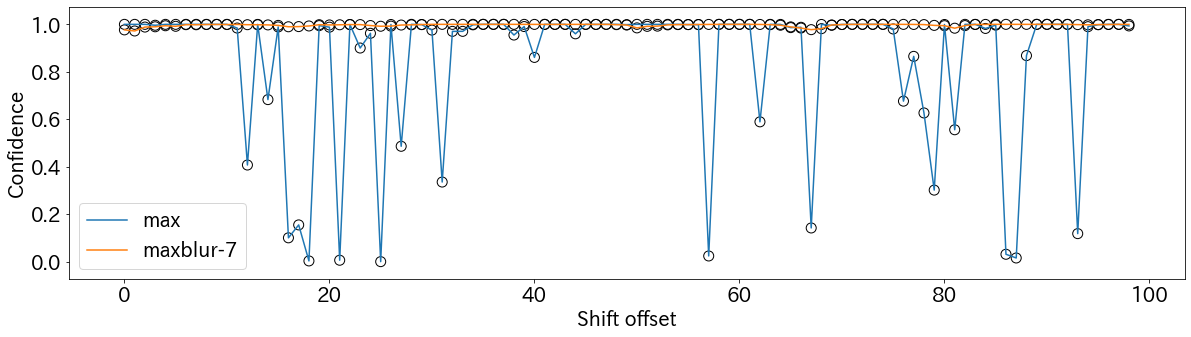

In [55]:
plt.figure(figsize=(20,5))
for pool_type in pool_types:
    confidence = confidence_dict[pool_type]
    plt.plot(confidence,label=pool_type)
    plt.scatter(x=list(range(99)),y=confidence,marker="o",c="",edgecolors="k",s=100)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Confidence",fontsize=20)
plt.xlabel("Shift offset",fontsize=20)
plt.legend(loc="lower left",fontsize=20)